# Compare phylogenetic LASSO solvers on simulated data sets.

Here, we compare the efficiency of two proximal gradient algorithms for solving the phylogenetic LASSO problem on simulated data sets. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import phyloinfer as pinf

In [5]:
import random
from model import PHY
from optimizer import ista, fista, raxml
from utils import saveTree, readTree

In [12]:
# JC model
pden = np.array([0.25, 0.25, 0.25, 0.25])
D, U, U_inv, rate_matrix = pinf.rateM.decompJC()

## simulation 1

In [290]:
random.seed(2017)
np.random.seed(2017)

# number of leaves
ntips = 100

# set branch lengths
branch = 0.05 * np.ones(2*ntips-3)

# randomly shrunking some branches
shrunken_idx = random.sample(range(2*ntips-3), 50)
branch[shrunken_idx] = 0.0

# set up the unresolved topology
sp_tree = pinf.tree.create(ntips, branch=branch)

# generate data
data_m1 = pinf.data.treeSimu(sp_tree, D, U, U_inv, pden, 1000)

In [291]:
# phylogenetic inference model
model = PHY(pden, ('JC', 1.0), data_m1)

In [292]:
lam = 1e-06
gamma = 1.0
beta = 0.5
wts = np.ones(2*ntips-3)

# load the initial branch length
brlen_init = np.load('../data/convergence/model1-br-init.npy')

# load the optimal estimate from a long run of pFISTA
optimal_m1 = np.load('../data/convergence/model1-optimal.npy')

In [293]:
# ISTA vs FISTA
brlen_ista, objval_ll_ista, objval_penalized_ista, lam_ista = ista(model, sp_tree, brlen_init, lam, gamma, beta, wts, maxiter=1000, abstol=1e-16)
brlen_fista, objval_ll_fista, objval_penalized_fista, lam_fista, niter_fista = fista(model, sp_tree, brlen_init, lam, gamma, beta, wts, maxiter=1000, abstol=1e-16, monitor=True)

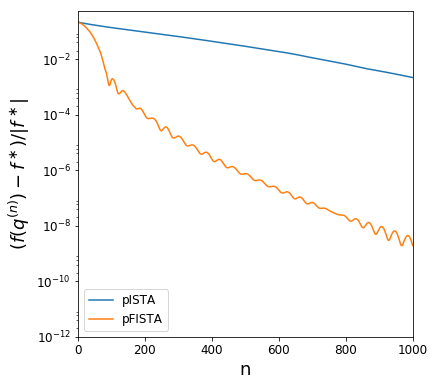

In [294]:
# show the result
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.semilogy((optimal_m1-objval_penalized_ista)/abs(optimal_m1), label='pISTA')
ax.semilogy((optimal_m1-objval_penalized_fista)/abs(optimal_m1), label='pFISTA')
ax.set_xlabel('n',fontsize=18)
ax.set_ylabel(r'$(f(q^{(n)})-f^\ast)/|f^\ast|$',fontsize=18)
ax.set_xlim([0,1000])
ax.set_ylim(bottom=1e-12)
ax.tick_params(labelsize=12)
ax.legend(loc=3, fontsize=12)

plt.show()

In [ ]:
# detected zero branches for different penalty coefficients

lam = 1e-06
gamma_list = [1, 5, 10, 20, 40, 80, 160]
beta = 0.5
wts = np.ones(2*ntips-3)
nzeros_list = []

brlen_init = np.random.exponential(scale=0.1, size=2*ntips-3)

for gamma in gamma_list:
    brlen_fista, objval_ll_fista, objval_penalized_fista, lam_fista, niter_fista = fista(model, sp_tree, brlen_init, lam, gamma, beta, wts, maxiter=1000, minstepsz=5e-08)
    nzeros_list.append(sum(brlen_fista==0.0))
    
    print "gamma {}; step size {}; iteration {}; # zeros {}".format(gamma, lam_fista, niter_fista, nzeros_list[-1])
    plt.plot(objval_ll_fista, label='pFISTA')
    plt.legend(loc='best', fontsize=15)
    plt.show()

## simulation 2

In [295]:
# load data
sp_tree = readTree('../data/simulation/true_tree_100tips_final.newick', tree_format=3)[0]
pinf.tree.init(sp_tree, name='interior')
data_m2, _ = pinf.data.loadData('../data/simulation/simulated_100tips_final.fasta', data_type='fasta')

# load the optimal estimate from a long run of pFISTA
optimal_m2 = np.load('../data/convergence/model2-optimal.npy')

In [296]:
# phylogenetic inference model
model = PHY(pden, ('JC', 1.0), data_m2)

In [297]:
lam = 1e-06
gamma = 1
beta = 0.5
wts = np.ones(2*ntips-3)

# initialize branch length
np.random.seed(2017)
brlen_init = np.random.exponential(scale=0.1, size=2*ntips-3)

In [ ]:
brlen_ista, objval_ll_ista, objval_penalized_ista, lam_ista = ista(model, sp_tree, brlen_init, lam, gamma, beta, wts, maxiter=1000, minstepsz=5e-08, abstol=1e-16)
brlen_fista, objval_ll_fista, objval_penalized_fista, lam_fista, niter_fista = fista(model, sp_tree, brlen_init, lam, gamma, beta, wts, maxiter=1000, minstepsz=5e-08, abstol=1e-16, monitor=True)
brlen_fista_partial_restart, objval_ll_fista_partial_restart, objval_penalized_fista_partial_restart, lam_fista_partial_restart, niter_fista_partial_restart = fista(model, sp_tree, brlen_init, lam, gamma, beta, wts, maxiter=1000, minstepsz=5e-08, abstol=1e-16, stepsz_restart=False, monitor=True)

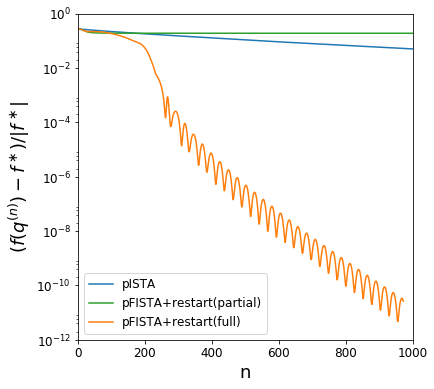

In [299]:
# show the result
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.semilogy((optimal_m2-objval_penalized_ista)/abs(optimal_m2), color='#1f77b4', label='pISTA')
ax.semilogy((optimal_m2-objval_penalized_fista_partial_restart)/abs(optimal_m2), color='#2ca02c', label='pFISTA+restart(partial)')
ax.semilogy((optimal_m2-objval_penalized_fista)/abs(optimal_m2), color='#ff7f0e',label='pFISTA+restart(full)')
        
ax.set_xlabel('n',fontsize=18)
ax.set_ylabel(r'$(f(q^{(n)})-f^\ast)/|f^\ast|$',fontsize=18)
ax.set_xlim([0,1000])
ax.set_ylim(bottom=1e-12)
ax.tick_params(labelsize=12)
ax.legend(loc=3, fontsize=12)

plt.show()

In [ ]:
# detected zero branches for different penalty coefficients

lam = 1e-06
gamma_list = [1, 5, 10, 20, 40, 80, 160]
beta = 0.5
wts = np.ones(2*ntips-3)
nzeros_list = []

brlen_init = np.random.exponential(scale=0.1, size=2*ntips-3)

for gamma in gamma_list:
    brlen_fista, objval_ll_fista, objval_penalized_fista, lam_fista, niter_fista = fista(model, sp_tree, brlen_init, lam, gamma, beta, wts, maxiter=2000, minstepsz=5e-08)
    nzeros_list.append(sum(brlen_fista==0.0))
    
    print "gamma {}; step size {}; iteration {}; # zeros {}".format(gamma, lam_fista, niter_fista, nzeros_list[-1])
    plt.plot(objval_ll_fista, label='pFISTA')
    plt.legend(loc='best', fontsize=15)
    plt.show()